In [1]:
import random
import math
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import least_squares, minimize

In [2]:
def generate_data(seed=None):
    random.seed(seed)
    alpha = random.random()
    betta = random.random()
    xs = np.linspace(0, 1, 101)
    ys = [alpha * x + betta + random.random() for x in xs]
    return xs, ys

seed = 1001
xs, ys = generate_data(seed=seed)

In [32]:
base_formulas = [lambda x, a, b: a * x + b, lambda x, a, b: a / (1 + b * x)]

def get_scorer(f):
    def scorer(a, b):
        return sum((f(x, a, b) - y) ** 2 for x, y in zip(xs, ys))
    return scorer

formulas = [get_scorer(base_formulas[i]) for i in range(2)]

base_gradients = [[lambda x, y, a, b: 2 * x * (a * x + b - y), lambda x, y, a, b: 2 * (a * x + b - y)], 
                  [lambda x, y, a, b: 2 * (a / (1 + b * x) ** 2 - y / (1 + b * x)), lambda x, y, a, b: 2 * a * x * (y / (1 + b * x) ** 2 - a / (1 + b * x) ** 3)]]

def get_scorer_g(fs):
    def scorer(a, b):
        return np.array([sum(fs[j](x, y, a, b) for x, y in zip(xs, ys)) for j in range(2)])
    return scorer

gradients = [get_scorer_g(base_gradients[i]) for i in range(2)]

base_hessians = [[[lambda x, y, a, b: 2 * x ** 2, lambda x, y, a, b: 2 * x],
                  [lambda x, y, a, b: 2 * x, lambda x, y, a, b: 2]],
                 [[lambda x, y, a, b: 2 / (1 + b * x) ** 2, lambda x, y, a, b: 2 * x * (y / (1 + b * x) ** 2 - a ** 2 / (1 + b * x) ** 3)],
                  [lambda x, y, a, b: 2 * x * (y / (1 + b * x) ** 2 - a ** 2 / (1 + b * x) ** 3), lambda x, y, a, b: 2 * a * x ** 2 * (3 * a / (1 + b * x) ** 4 - 2 * y / (1 + b * x) ** 3)]]]

def get_scorer_h(hmat):
    def scorer(a, b):
        return np.array([[sum(hmat[j][k](x, y, a, b) for x, y in zip(xs, ys)) for k in range(2)] for j in range(2)])
    return scorer

hessians = [get_scorer_h(base_hessians[i]) for i in range(2)]

In [33]:
[formulas[i](0.1,0.1) for i in range(2)], [gradients[i](0.1,0.1) for i in range(2)],  [hessians[i](0.1,0.1) for i in range(2)]

([77.84384297827896, 88.27691294544816],
 [array([ -91.72695471, -161.93933455]),
  array([-163.73685404,    8.63489456])],
 [array([[ 67.67, 101.  ],
         [101.  , 202.  ]]),
  array([[183.64471099,  93.85451241],
         [ 93.85451241, -10.89489837]])])

In [63]:
def gradient_descent(f, g, h=None, lr=0.0001, eps=0.001, seed=None):
    random.seed(seed)
    coeffs = np.array([random.random(), random.random()])
    f_num = 1
    f_cur = f(*coeffs)
    iter_num = 0
    f_prev = None
    pbar = tqdm()
    while f_prev is None or abs(f_prev - f_cur) > eps:
        iter_num += 1
        f_num += 2
        
        grad_cur = g(*coeffs)
        if f_prev is not None:
            lr = (coeffs - coeffs_prev).dot(grad_cur - grad_prev) / np.linalg.norm(grad_cur - grad_prev) ** 2  # Barzilai-Borwein
        coeffs_prev = coeffs
        coeffs = coeffs - lr * grad_cur
        f_cur, f_prev = f(*coeffs), f_cur
        grad_prev = grad_cur
        
        pbar.update()
    pbar.close()
    return f_num, iter_num, f_cur, coeffs

def conjugate_gradient_descent(f, g, h=None, lr=0.001, eps=0.001, seed=None):
    random.seed(seed)
    coeffs = np.array([random.random(), random.random()])
    f_num = 4
    iter_num = 1
    
    f_cur, delta_cur = f(*coeffs), - g(*coeffs)
    coeffs -= delta_cur * lr
    
    f_prev, f_cur = f_cur, f(*coeffs)
    delta_prev, delta_cur = delta_cur, - g(*coeffs)
    betta = delta_cur.T.dot(delta_cur - delta_prev) / delta_prev.T.dot(delta_prev)  # Polak-Ribiere
    s_prev, s_cur = delta_prev, delta_cur * betta
    
    pbar = tqdm()
    while abs(f_prev - f_cur) > eps:
        iter_num += 1
        f_num += 2
        
        coeffs += lr * s_cur
        f_prev, f_cur = f_cur, f(*coeffs)
        delta_prev, delta_cur = delta_cur, - g(*coeffs)
        betta = delta_cur.T.dot(delta_cur - delta_prev) / delta_prev.T.dot(delta_prev)
        s_prev, s_cur = s_cur, delta_cur + s_prev * betta
        
        pbar.update()
    pbar.close()
    return f_num, iter_num, f_cur, coeffs

def conjugate_gradient_descent(f, g, h=None, lr=0.001, eps=0.001, seed=None):
    random.seed(seed)
    coeffs = np.array([random.random(), random.random()])
    f_mod, g_mod = lambda x: f(*x), lambda x: g(*x)
    res = minimize(f_mod, x0=coeffs, method='CG', jac=g_mod, tol=eps)
    return res.nfev + res.njev, res.nit, res.fun, res.x

def Newton_method(f, g, h, lr=0.001, eps=0.001, seed=None):
    random.seed(seed)
    coeffs = np.array([random.random(), random.random()])
    f_mod, g_mod, h_mod = lambda x: f(*x), lambda x: g(*x), lambda x: h(*x),
    res = minimize(f_mod, x0=coeffs, method='Newton-CG', jac=g_mod, hess=h_mod, tol=eps)
    return res.nfev + res.nhev + res.njev, res.nit, res.fun, res.x

def Levenberg_Marquardt_algorithm(f_base, lr=0.001, eps=0.001, seed=None):
    random.seed(seed)
    coeffs = np.array([random.random(), random.random()])
    mod_f = lambda x: f(*x)
    res = least_squares(lambda c: [(f_base(x, *c) - y) ** 2 for x, y in zip(xs, ys)], x0=np.array([0, 0]), method='lm', xtol=eps, ftol=eps)
    return res.nfev, res.nfev // 2, sum((f_base(x, *res.x) - y) ** 2 for x, y in zip(xs, ys)), res.x

In [64]:
results = pd.read_csv('lab2_results.csv')
formula_repr = results.Formula.unique()
method_repr = ['Gradient Descent', 'Conjugate Gradient Descent', 'Newton\'s method', 'Levenberg-Marquardt algorithm']
eps = 0.0001

for i in range(2):
    for j, method in enumerate((gradient_descent, conjugate_gradient_descent, Newton_method)):
        f_num, iter_num, f_cur, coeffs = method(formulas[i], gradients[i], hessians[i], seed=seed, eps=eps)
        results = results.append({'Method': method_repr[j], 'Formula': formula_repr[i], 'Number of iterations': iter_num,\
                                  'Number of function calls': f_num, 'Found F minimum': f_cur, 'a': coeffs[0], 'b': coeffs[1]},\
                                  ignore_index=True)
    f_num, iter_num, f_cur, coeffs = Levenberg_Marquardt_algorithm(base_formulas[i], eps=eps)
    results = results.append({'Method': method_repr[3], 'Formula': formula_repr[i], 'Number of iterations': iter_num,\
                              'Number of function calls': f_num, 'Found F minimum': f_cur, 'a': coeffs[0], 'b': coeffs[1]},\
                              ignore_index=True)
results

0it [00:00, ?it/s]

0it [00:00, ?it/s]

,Method,Formula,Number of iterations,Number of function calls,Found F minimum,a,b
0,Exhaustive search,a * x + b,1000000,1000000,9.562299,0.727728,0.587588
1,Exhaustive search,a / (1 + b * x),1000000,1000000,9.239988,0.657658,-0.545546
2,Gauss,a * x + b,20000,20001,9.565516,0.745746,0.579580
3,Gauss,a / (1 + b * x),30000,30001,9.245150,0.647648,-0.555556
4,Nelder Mead,a * x + b,47,86,9.562282,0.726212,0.588537
5,Nelder Mead,a / (1 + b * x),39,73,9.239958,0.657284,-0.545673
6,Gradient Descent,a * x + b,5,11,9.562282,0.726516,0.588421
7,Conjugate Gradient Descent,a * x + b,2,10,9.562282,0.726516,0.588422
8,Newton's method,a * x + b,3,9,9.562282,0.726516,0.588422
9,Levenberg-Marquardt algorithm,a * x + b,14,28,9.595804,0.784064,0.552548


In [72]:
results['method_order'] = results.Method.map(lambda x: list(results.Method.unique()).index(x))

In [74]:
results.sort_values(['Formula', 'method_order']).to_csv('lab3.csv', )

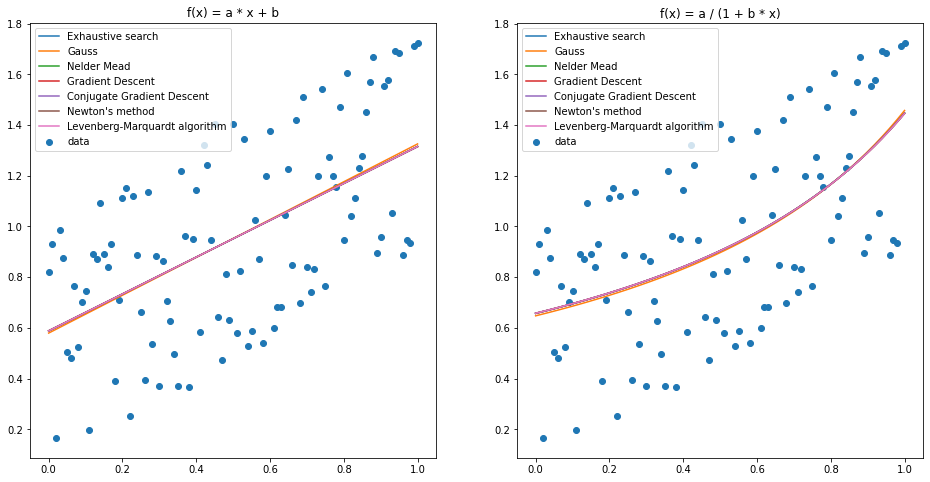

In [81]:
fig, axs = plt.subplots(1, 2, sharex=True, figsize=(16, 8))
x_domain = np.linspace(0, 1)
for i in range(2):
    axs[i].set_title('f(x) = ' + formula_repr[i])
    axs[i].scatter(x=xs, y=ys)
    to_legend = []
    for _, row in results[results['Formula'] == formula_repr[i]].iterrows():
        a, b = row['a'], row['b']
        axs[i].plot(x_domain, [base_formulas[i](x, a, b) for x in x_domain])
        to_legend.append(row['Method'])
    axs[i].legend(to_legend + ['data'])